Для каждого человека на все его фотографии накладывается каждое закрытие. Для всех чистых и закрытых фотографий вычисляются векторы в латентом пространстве, после чего вычисляется среднее внутрикластерное расстояние для векторов незакрытых фотографий $r$ и среднее междукластерное расстояние для кластеров чистых и закрытых фотографий $R$. На графиках для каждого закрытия приводятся гистограммы распределений величин $R - r$ (Absolute distance difference) и $(R-r)/r$ (Relative distance difference). Кроме того, для каждого закрытия и для каждой пары фотографий одного человека вычисляется доля случаев, когда человек распознавался моделью до закрытия и перестал распознаваться после. Формат названия закрытия: <Глаза><Рот><Голова>, слово Identity на любой из позиций означает отсутствие закрытия.

In [1]:
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageColor
from psd_tools import PSDImage
from scipy.spatial import distance_matrix
from tqdm import tqdm
import dlib
import itertools
import numpy as np
import pandas as pd
import path
import pickle
import Obstruct
import os
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
DIR = './LFWcrop/faces'
IMAGE_LIST = path.glob.glob(DIR + '/*')
model = dlib.face_recognition_model_v1("models/dlib_face_recognition_resnet_model_v1.dat")
N = 1680
THRESHOLD = 0.6

In [3]:
def extract_name(img):
    return "_".join(img.split('/')[-1].split('_')[:-1])

In [4]:
IMAGE_LISTS_NAMES = [x for x in [(name, list(gen))\
                                 for name, gen in\
                                 itertools.groupby(sorted(IMAGE_LIST), key=extract_name)] if len(x[1]) > 1]

In [5]:
def Identity(x):
    return x

def Eyepatch(x):
    return Obstruct.obstructEyesEyepatch(x)

def Sunglasses(x):
    return Obstruct.obstructEyesSunglasses(x)

def BlackMask(x):
    return Obstruct.obstructMouthBlackMask(x)

def Scarf(x):
    return Obstruct.obstructMouthScarf(x)

def WhiteMask(x):
    return Obstruct.obstructMouthWhiteMask(x)

def Hood(x):
    return Obstruct.obstructHeadHood(x)

eyes_augs = [Identity, Eyepatch, Sunglasses]
mouth_augs = [Identity, BlackMask, Scarf, WhiteMask]
head_augs = [Identity, Hood]

def compose(augs):
    def plc(x):
        for aug in augs:
            x = aug(x)
        return x
    return plc

In [6]:
def LFWcropLabelGenerator_by_name_noimg(augmentation, shape=(150, 150), verbose=False):
    for name, imagelist in IMAGE_LISTS_NAMES:
        if verbose:
            print(name)
        images = []
        for img in imagelist:
            img = Image.open(img).resize(shape)
            images.append(np.array(img))
        for img in imagelist:
            img = Image.open(img).resize(shape)
            images.append(np.array(augmentation(img).convert("RGB")))
        images = np.stack(images, axis=0)
        yield name, images

In [7]:
tobe_df = {
    "aug": [],
    "data": np.zeros((24, 2, N)),
    "proba": []
}
for i, (eyes, mouth, head) in enumerate(itertools.product(eyes_augs, mouth_augs, head_augs)):
    augmentation = compose([eyes, mouth, head])
    aug_name = eyes.__name__ + mouth.__name__ + head.__name__
    
    init_identified = 0
    aug_unidentified = 0
    for j, (name, images) in tqdm(enumerate(LFWcropLabelGenerator_by_name_noimg(augmentation))):
        descs = np.array(model.compute_face_descriptor(images))
        num_img = descs.shape[0] // 2
        init_matrix = distance_matrix(descs[:num_img], descs[:num_img])
        init_diff = init_matrix.sum() / (num_img * (num_img - 1))
        aug_matrix = distance_matrix(descs[:num_img], descs[num_img:])
        aug_diff = (aug_matrix.sum() - np.trace(aug_matrix)) / (num_img * (num_img - 1))
        
        init_identified += ((init_matrix > 0) & (init_matrix <= THRESHOLD)).sum()
        aug_unidentified += ((init_matrix > 0) & (init_matrix <= THRESHOLD) & (aug_matrix > THRESHOLD)).sum()
        
        tobe_df["data"][i, 0, j] = init_diff
        tobe_df["data"][i, 1, j] = aug_diff
    tobe_df["aug"].append(aug_name)
    tobe_df["proba"].append(aug_unidentified / init_identified)

1680it [01:37, 20.88it/s]
1680it [00:56, 29.89it/s]
1680it [00:55, 30.06it/s]
1680it [01:01, 29.75it/s]
1680it [00:55, 30.13it/s]
1680it [01:01, 29.97it/s]
1680it [00:55, 30.22it/s]
1680it [01:01, 29.50it/s]
1680it [00:55, 30.31it/s]
1680it [01:01, 29.84it/s]
1680it [01:01, 29.61it/s]
1680it [01:07, 24.93it/s]
1680it [01:00, 27.74it/s]
1680it [01:06, 25.27it/s]
1680it [01:00, 27.78it/s]
1680it [01:06, 25.39it/s]
1680it [00:55, 30.40it/s]
1680it [01:01, 30.14it/s]
1680it [01:00, 29.99it/s]
1680it [01:06, 25.20it/s]
1680it [01:03, 26.30it/s]
1680it [01:13, 22.96it/s]
1680it [01:09, 24.17it/s]
1680it [01:13, 22.83it/s]


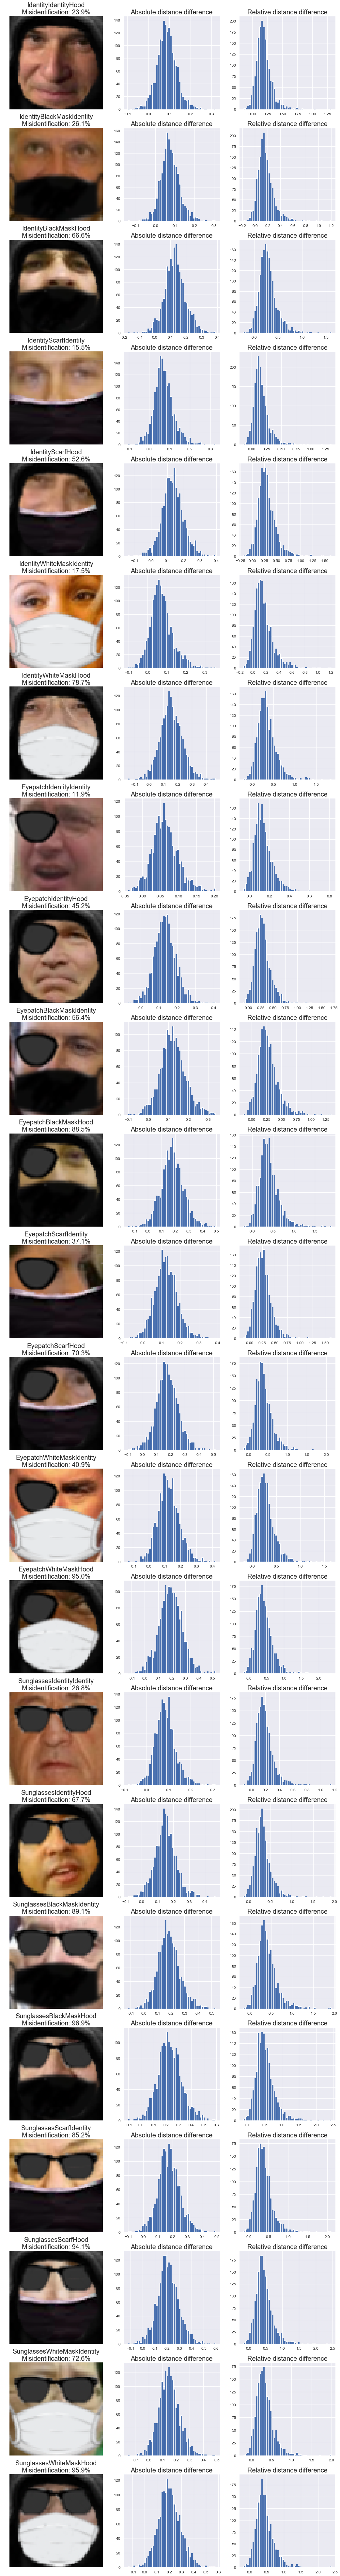

In [8]:
imges = [Obstruct.getRandomImageList(IMAGE_LIST) for _ in range(24)]
plt.figure(figsize=(18, 150))
for idx, (eyes, mouth, head) in enumerate(itertools.product(eyes_augs, mouth_augs, head_augs)):
    if idx == 0:
        continue
    plt.subplot(24, 3, 3*idx+1)
    augmentation = compose([eyes, mouth, head])
    aug_name = eyes.__name__ + mouth.__name__ + head.__name__
    aug_dist = tobe_df['data'][idx, 1, :]
    init_dist = tobe_df['data'][idx, 0, :]
    proba = tobe_df['proba'][idx]
    plt.imshow(augmentation(imges[idx]))
    plt.axis("off")
    plt.title(aug_name + '\n' + "Misidentification: " + str(np.round(100 * proba, 1)) + "%", fontsize=20)
    plt.subplot(24, 3, 3*idx+2)
    plt.hist(aug_dist - init_dist, bins=50)
    plt.title("Absolute distance difference", fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.subplot(24, 3, 3*idx+3)
    plt.hist((aug_dist - init_dist)/init_dist, bins=50)
    plt.title("Relative distance difference", fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
plt.savefig('distributions_averaged.pdf', format='pdf')

In [16]:
tobe_table = {
    "Augmentation": ["IdentityIdentityIdentity"],
    "Probability": [0.0]
}
for idx, (eyes, mouth, head) in enumerate(itertools.product(eyes_augs, mouth_augs, head_augs)):
    if idx == 0:
        continue
    tobe_table["Augmentation"].append(eyes.__name__ + mouth.__name__ + head.__name__)
    tobe_table["Probability"].append(tobe_df['proba'][idx])
table = pd.DataFrame(tobe_table).sort_values("Probability").set_index("Augmentation")
display(table)

,Probability
Augmentation,
IdentityIdentityIdentity,0.000000
EyepatchIdentityIdentity,0.118671
IdentityScarfIdentity,0.155068
IdentityWhiteMaskIdentity,0.174750
IdentityIdentityHood,0.238802
IdentityBlackMaskIdentity,0.261014
SunglassesIdentityIdentity,0.267709
EyepatchScarfIdentity,0.371213
EyepatchWhiteMaskIdentity,0.408505
